# Treinamento de Modelo
## Descrição

Esse é o primeiro código de treinamento de um modelo. É uma pipeline simples, com o carregamento do dataset, a divisão do conjunto de dados em treino e validação (ainda sem conjunto de testes), o treinamento do modelo e a validação.

## Imports

In [1]:
import os
import sys
from time import time

import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.utils import shuffle

import mlflow
from mlflow.tracking import MlflowClient


import matplotlib.pyplot as plt
import seaborn as sns

## Extração de Dados

In [2]:
def read_data(url):
    return pd.read_csv(os.path.abspath(url))

In [3]:
df = read_data("../extracao/datanov2.csv")

In [4]:
df

,edge_simpl,hue_simpl,average_lum,contrast_ratio,hist_width,blur,score
10004473376.jpg,0.001081,7,41.526758,0.000000,0.003876,0.498065,77.383621
10007357496.jpg,0.001082,17,66.373103,0.008127,0.003110,0.495744,68.728571
10007903636.jpg,0.001081,16,54.814935,0.000000,0.003324,0.494343,78.628571
10009096245.jpg,0.001079,17,14.681202,0.000000,0.002972,0.497337,77.243750
100117038.jpg,0.001083,14,77.800492,0.000000,0.003171,0.494853,75.112500
...,...,...,...,...,...,...,...
9984535544.jpg,0.001082,18,39.107523,0.000000,0.002037,0.501049,70.020089
9991658304.jpg,0.001080,14,44.251944,0.000000,0.003891,0.498962,79.337838
9991999836.jpg,0.001080,17,57.842979,0.002332,0.003753,0.499522,78.092437
9995874256.jpg,0.001082,17,62.265024,0.011355,0.003661,0.493174,68.095133


## Formatação dos Dados

Divisão entre os conjuntos de treinamento e de validação. O dataset está ordenado pela qualidade das imagens (alvo da regressão), logo é necessário embaralhar os dados para evitar viés.

Em uma etapa posterior, será utilizada validação cruzada para se ter uma estimativa da precisão das métricas aplicadas.

In [8]:
def getXy(df):
    r_state = 15
    df = shuffle(df, random_state=r_state)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y
r_state = 12
X, y = getXy(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=r_state
)


## Treinamento

Aqui é utilizado um modelo de regressão linear como teste.

In [21]:
model = RandomForestRegressor(max_depth=9,max_features=3,min_samples_split=20,min_samples_leaf=4,n_estimators=100)

In [14]:
model= LinearRegression(fit_intercept=False)

In [22]:
now = time()
model.fit(X_train, y_train)


RandomForestRegressor(max_depth=9, max_features=3, min_samples_leaf=4,
                      min_samples_split=20)

## Validação

As métricas utilizadas são a Raíz do Erro Quadrático Médio (rmse), o erro absoluto médio (mae) e coeficiente de determinação (r2), que nos diz o quão bem os dados se encaixam no modelo. 

In [10]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [23]:
y_pred_test = model.predict(X_test)
rmse, mae, r2 = eval_metrics(y_test, y_pred_test)
print (f"Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")

y_pred_train = model.predict(X_train)
rmse, mae, r2 = eval_metrics(y_train, y_pred_train)
print (f"Desempenho no conjunto de Treino\nrmse:{rmse}    mae:{mae}    r2:{r2}")



Desempenho no conjunto de Testes (Validação)
rmse:12.233536720519801    mae:9.533568991717658    r2:0.33974344365464093
Desempenho no conjunto de Treino
rmse:11.669239657018414    mae:9.125183391493778    r2:0.43954150413082016


Vemos que o desempenho do modelo é baixo, com coeficiente de determinação de 0.19. Além disso, comparando os desempenhos do conjunto de treino e do conjunto de testes, vemos que o modelo não está realizando overfitting. O desempenho no conjunto de testes é ligeiramente melhor do que no conjunto de treino, o que sugere um pequeno underfitting, o que é condizente com a simplicidade do modelo de regressão linear.

## Registro dos Resultados

### Inicialização do cliente MLFlow

Tanto esse notebook quanto o MLFlow devem estar rodando em uma mesma máquina hospedeira. É necessário passar o IP da máquina na rede local para realizar a conexão.

In [19]:
def connectMLFlow(MLFlowAddr):
    client = MlflowClient(tracking_uri=MLFlowAddr)
    mlflow.set_tracking_uri(MLFlowAddr)
    return client

In [21]:
client = connectMLFlow("http://172.27.0.1:5000")

In [121]:
experiment_name = "Simple Model"
try:
    experiment_id = client.create_experiment(experiment_name)
except:
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id
    
experiment = mlflow.set_experiment(experiment_name)

In [122]:
run_name = "LinearRegression_default_params"
rmse, mae, r2 = eval_metrics(y_test,y_pred_test)
with mlflow.start_run(run_name=run_name) as run:
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.end_run()

## Análise dos Resultados

Segue uma breve analise do desempenho do modelo e da importância das features.

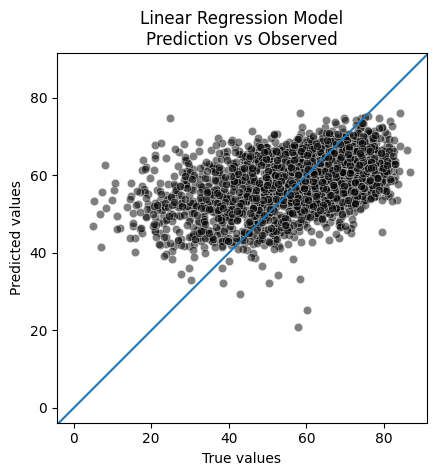

In [17]:
predicted_actual = {
    "True values": y_test, "Predicted values": y_pred_test}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
_ = plt.title("Linear Regression Model\nPrediction vs Observed")

### Análise da Importância das Features no Modelo

Em um modelo de regressão linear, cada característica está relacionada a um coeficiente, que pode ser interpretado como a taxa de variação da função objetivo em relação a uma mudança na característica correspondente, mantendo as outras constantes.

No gráfico abaixo, podemos ver a magnitude de cada coeficiente.

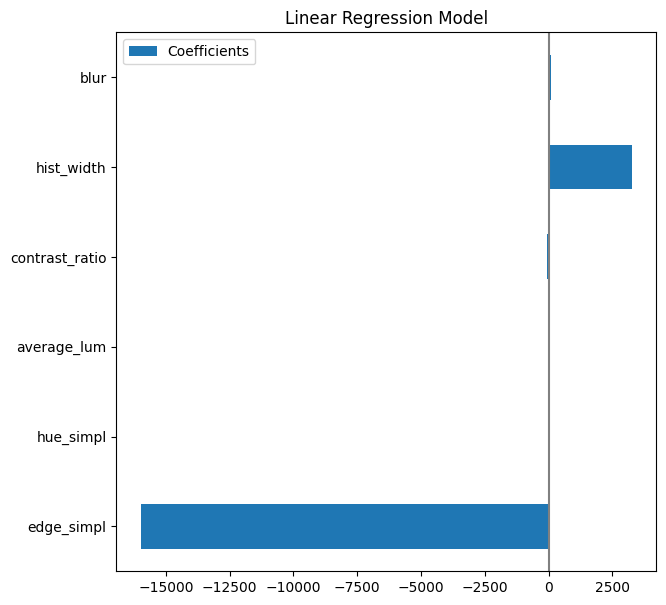

In [18]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear Regression Model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

Vemos que uma mudança no desfoque é a que mais impacta o score, mas ainda não podemos concluir que essa é a característica mais importnate. É preciso levar em consideração a escala das variações das características, pois, se houver pouca variação nos dados, mesmo um coeficiente alto pode ter pouco impacto no score predito.

Essa variação pode ser visualizada com o desvio padrão. O framework Pandas oferece medidas de resumo dos dataframes:

In [19]:
X.describe()

,edge_simpl,hue_simpl,average_lum,contrast_ratio,hist_width,blur
count,10073.000000,10073.000000,10073.000000,10073.000000,10073.000000,10073.000000
mean,0.001071,14.087561,45.261248,0.014932,0.003399,0.498686
std,0.000044,4.156595,21.172676,0.048479,0.000643,0.006485
min,0.000283,0.000000,1.881522,0.000000,0.000521,0.455504
25%,0.001080,12.000000,28.055609,0.000000,0.003186,0.496759
50%,0.001081,15.000000,46.421272,0.000000,0.003676,0.498952
75%,0.001082,17.000000,62.363196,0.007732,0.003860,0.500788
max,0.001106,19.000000,89.700541,0.621497,0.003891,0.574385


Vemos que as 4 características com os maiores coeficientes (que são visíveis no gráfico acima) possuem desvio padrão menor que um, sendo que o desfoque (blur) é o menor deles, com 0.006462. Isso pode ser a causa do destaque dessas caracteŕisticas no gráfico acima.

Abaixo, é feita um pipeline com um scaler padrão, que transforma os dados de entrada para que tenham média 0 e desvio padrão igual à 1. Plotando os coeficientes do novo modelo, podemos ver que a luminância média é que tem maior importância, seguida do contraste e largura do histograma. São as três características que fazem o conjunto de simplicidade de luminância.

In [20]:
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)


y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print (f"Desempenho no conjunto de Testes (Validação): {eval_metrics(y_test,y_pred_test)}")
print (f"Desempenho no conjunto de Treino: {eval_metrics(y_train,y_pred_train)}")

Desempenho no conjunto de Testes (Validação): (13.304689100745177, 10.520632040573114, 0.21905918062654162)
Desempenho no conjunto de Treino: (14.015552358679347, 11.088443479883885, 0.19150232614317286)


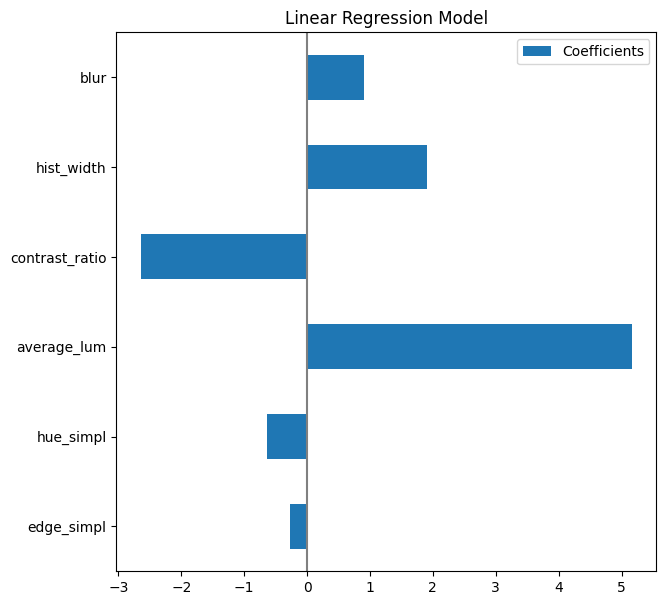

In [147]:
coefs = pd.DataFrame(
   model[1].coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Linear Regression Model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)


### Comparação das Características com Ruído

In [50]:
y = shuffle(y, random_state = 10)
noiseModel = LinearRegression()

X_trainNoise, X_testNoise, y_trainNoise, y_testNoise = train_test_split(
    X, y, test_size=0.3, random_state=r_state
)

noiseModel.fit(X_trainNoise, y_trainNoise)

LinearRegression()

In [51]:
y_predNoise = noiseModel.predict(X_testNoise)
rmse, mae, r2 = eval_metrics(y_test, y_predNoise)
print (f"Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")


Desempenho no conjunto de Testes (Validação)
rmse:14.60483615692295    mae:11.937517559803581    r2:-0.00020793735051150009


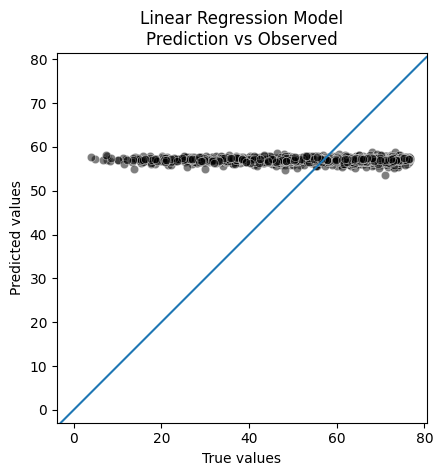

In [52]:
predicted_actual = {
    "True values": y_testNoise, "Predicted values": y_predNoise}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
_ = plt.title("Linear Regression Model\nPrediction vs Observed")